<a href="https://colab.research.google.com/github/GeneSUN/time-series-analysis-toolkit/blob/main/Temporal_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O time_series_inspectors.py "https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Analyzing%20and%20Visualizing/time_series_inspectors.py"

from time_series_inspectors import BaseTimeSeriesInspector, TrendInspector, SeasonalityInspector, HeteroscedasticityInspector

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install sktime

In [15]:
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.fourier import FourierFeatures


In [40]:
import pandas as pd

url = "https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Data/df_cap_hour_pd.csv"
df_cap_hour_pd = pd.read_csv(url).rename(columns={'avg_4gsnr': 'feature1', 'avg_5gsnr': 'feature2'})\
                  .drop( columns =["feature2"]  )
df_cap_hour_pd['hour'] = pd.to_datetime(df_cap_hour_pd['hour'])
df_daily = df_cap_hour_pd.resample('D', on='hour').mean(numeric_only=True).reset_index().rename(columns={'hour': 'day'})
display(df_daily.head())

,day,feature1
0,2025-03-27 00:00:00-04:00,14.600000
1,2025-03-28 00:00:00-04:00,15.166667
2,2025-03-29 00:00:00-04:00,15.916667
3,2025-03-30 00:00:00-04:00,15.909091
4,2025-03-31 00:00:00-04:00,15.272727



1. 📈 Plot Original Time Series

--- 🔍 Step: Visual Inspection ---
Purpose: Observe overall shape, amplitude, and possible patterns.



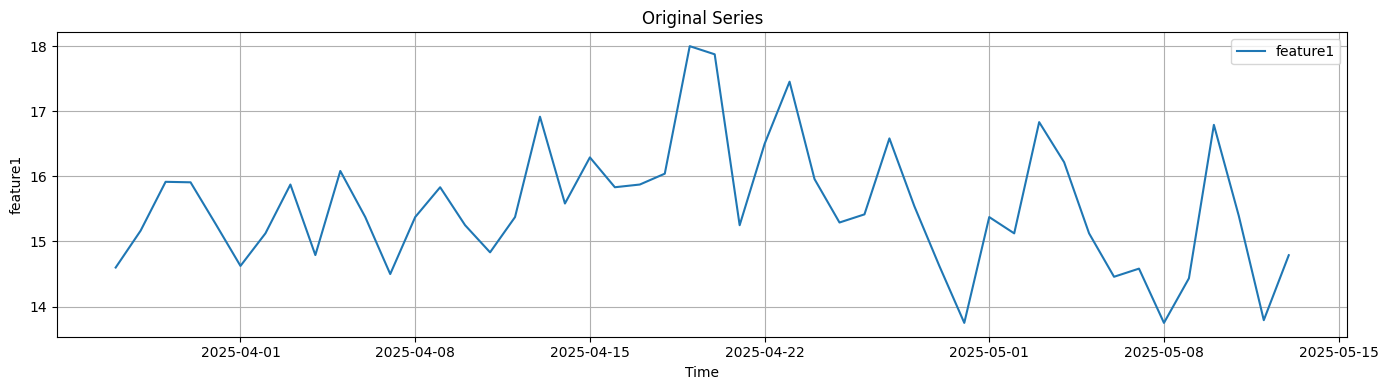

In [12]:

base_inspector = BaseTimeSeriesInspector(df_daily, datetime_col='day', value_col='feature1')
print("\n1. 📈 Plot Original Time Series")
base_inspector.plot_series()

# Seasonal dummies

In [34]:
from sktime.transformations.series.date import DateTimeFeatures

datetime_features = DateTimeFeatures(manual_selection=['day_of_week', 'month_of_year'])
df_daily_seasonality_dt = datetime_features.fit_transform(df_daily.set_index('day'))

df_daily_with_seasonality = pd.concat([df_daily.set_index('day'), df_daily_seasonality_dt], axis=1).reset_index()

display(df_daily_with_seasonality.head())

,day,feature1,month_of_year,day_of_week
0,2025-03-27 00:00:00-04:00,14.600000,3,3
1,2025-03-28 00:00:00-04:00,15.166667,3,4
2,2025-03-29 00:00:00-04:00,15.916667,3,5
3,2025-03-30 00:00:00-04:00,15.909091,3,6
4,2025-03-31 00:00:00-04:00,15.272727,3,0


In [39]:
df_encoded = pd.get_dummies(df_daily_with_seasonality, columns=["day_of_week"], prefix="weekday", dtype=int)

df_encoded.head(3)

,day,feature1,month_of_year,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2025-03-27 00:00:00-04:00,14.600000,3,0,0,0,1,0,0,0
1,2025-03-28 00:00:00-04:00,15.166667,3,0,0,0,0,1,0,0
2,2025-03-29 00:00:00-04:00,15.916667,3,0,0,0,0,0,1,0


# Fourier series

In [29]:
from sktime.transformations.series.fourier import FourierFeatures

fourier_features = FourierFeatures(sp_list=[7, 365], fourier_terms_list=[2, 5]) # Assuming weekly and yearly seasonality
df_daily_seasonality_fourier = fourier_features.fit_transform(df_daily.set_index('day'))

df_daily_with_seasonality = pd.concat([df_daily.set_index('day'), df_daily_seasonality_fourier], axis=1).reset_index()

display(df_daily_with_seasonality.head())


,day,feature1,sin_7_1,cos_7_1,sin_7_2,cos_7_2,sin_365_1,cos_365_1,sin_365_2,cos_365_2,sin_365_3,cos_365_3,sin_365_4,cos_365_4,sin_365_5,cos_365_5
0,2025-03-27 00:00:00-04:00,14.600000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2025-03-28 00:00:00-04:00,15.166667,0.781831,0.623490,0.974928,-0.222521,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,0.085965,0.996298
2,2025-03-29 00:00:00-04:00,15.916667,0.974928,-0.222521,-0.433884,-0.900969,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,0.171293,0.985220
3,2025-03-30 00:00:00-04:00,15.909091,0.433884,-0.900969,-0.781831,0.623490,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,0.255353,0.966848
4,2025-03-31 00:00:00-04:00,15.272727,-0.433884,-0.900969,0.781831,0.623490,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,0.337523,0.941317
